In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where date_time >= NOW() - '1 day'::INTERVAL;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)




In [49]:
df

index                                      cleaned_tweet  \
0          0  these new age rappers are ass and lame af. i d...   
1          1       i just let out my loudest "ahhhhhhhhh" ever    
2          2                          better jan the original?    
3          3   there was no cover up and never has been and ...   
4          4                               prefect fucken shoot   
5          5  guess where i'm at? in the clouds. dreams comi...   
6          6                            i feel so disrespected    
7          7                                            ofmndkx   
8          8                                      exactly renzo   
9          9                                       crazy right?   
10        10                                       freakin cold   
11        11            i can't believe my friends got married    
12        12                                        i'm hungry    
13        13                                      crying inside   
14        14                            lmao we'll keep looking   
15        15                                 i need motivation    
16        16      my sister nvr wants to share her shoes w/ me.   
17        17                                 in love with shoes   
18        18                                          womp womp   
19        19  super proud of this girl❤️michigan here she co...   
20        20                                           the read   
21        21                                           foreal     
22        22                      it's the magic of summer time   
23        23                               auntie maxine ftw!     
24        24  #welcometomylife made me cry and laugh chris b...   
25        25                              dirty looks, ~my guy~   
26        26                                disneyland part 2🤑    
27        27    my life is day by day turning into fucking shit   
28        28     work hard play hard is too real; i need chill.   
29        29                             hoes, hoes everywhere    
...      ...                                                ...   
57075  57075  join my live video on insta and talk to me y'a...   
57076  57076                     like english class i'm jk ily    
57077  57077        diego doesn't shut the fuck up with xie xie   
57078  57078  with my 89 year old mother after she fell. wai...   
57079  57079                                         goodnight    
57080  57080  model sheet of the wolf for peter and the wolf...   
57081  57081  it's a struggle having thighs a size 11 and a ...   
57082  57082                                 i love you though    
57083  57083                         this pen is seriously bomb   
57084  57084  dating island men or any other non american yo...   
57085  57085   imo "the quislings and party men who looked a...   
57086  57086                    i think we should pray for her    
57087  57087  #lost  #siamese #ragdoll cat whittier 90606, c...   
57088  57088    1/2 way through saturation and it's so goooood    
57089  57089                                where's the pump :/   
57090  57090  i got a's in both of my classes  lmao it's two...   
57091  57091                                   yooo this slaps    
57092  57092                                  so you like ducks   
57093  57093   if a train leaves baltimore going 85mph and a...   
57094  57094                                         no prob !!   
57095  57095  i'm afraid that i'm kramer. brb taking a seinf...   
57096  57096  this line was supposed to be 2 hours long. i t...   
57097  57097  having dinner with my son at the happiest plac...   
57098  57098  people!  for some reason we have an overwhelmi...   
57099  57099  when i find my nunu we gone be together foreev...   
57100  57100                 do you deserve weed, this weekend?   
57101  57101  i stab, i cut, i taze, i mace, i sue... but, h...   
57102  57102  #writtenonmytombstone shouldn't have wen

In [60]:
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
#df['dayofweek'] = df.created_datetime.apply(lambda x: x.dayofweek)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)

In [54]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[b'hashtag_mean_arr_window22',
 b'tweet_tfidf_fit_transform',
 b'hashtag_mean_arr_window5',
 b'hashtag_mean_arr_window14',
 b'hashtag_mean_arr_window19',
 b'hashtag_mean_arr_window3',
 b'hashtag_mean_arr_window8',
 b'hashtag_mean_arr_window0',
 b'tweet_SVD_fit',
 b'hashtag_mean_arr_window18',
 b'hashtag_mean_arr_window21',
 b'hashtag_mean_arr_window16',
 b'hashtag_mean_arr_window7',
 b'hashtags_tfidf_fit_transform',
 b'hashtag_mean_arr_window10',
 b'hashtag_mean_arr_window4',
 b'hashtag_mean_arr_window17',
 b'tweet_tfidf_fit',
 b'hashtag_mean_arr_window12',
 b'hashtags_countvec_fit',
 b'hashtag_mean_arr_window2',
 b'hashtag_mean_arr_window13',
 b'hashtag_mean_arr_window1',
 b'hashtag_mean_arr_window6',
 b'hashtag_mean_arr_window23',
 b'hashtag_mean_arr_window20',
 b'hashtag_mean_arr_window11',
 b'hashtag_mean_arr_window15',
 b'hashtags_countvec_fit_transform',
 b'hashtag_mean_arr_window9']

In [55]:
hastages_series = df['hashtags']

In [56]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec_fit = count_vectorizer.fit(hastages_series)
hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
r.set('hashtags_countvec_fit_temp', hashtags_countvec)

True

In [57]:
hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [61]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-08 05:05:39 
 end time:   2017-06-09 05:05:37 
 total hours:  23 
 time lag:  2:00:00 
 time gap:  1:00:00 
 time windows:  24


In [64]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = 2)
time_gap = timedelta(hours = 1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    start_time = min(df['created_datetime'])
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    arr = np.array(arr)  
    
    grad = np.gradient(arr)
    tr = np.argwhere(grad>.01).reshape(1,-1)[0]
    spikes = []
    [spikes.append(i) for i in tr if (i-1) not in tr]
    plt.figure(figsize=(14,7))
    plt.plot(arr, label='Hashtag Frequency')
    plt.plot(grad, label='Frequency Slope')
    
    for i,j in enumerate(spikes):
        spiketime = (min(df['created_datetime']) + time_gap * j) 
        spiketime = spiketime.replace(tzinfo=from_zone)
        spiketime_et = spiketime.astimezone(to_zone)
        spiketime_et = spiketime_et.strftime(time_format)
        
        plt.axvline(j, color = 'r',linestyle='dashed', label = 'Trending: {}'.format(spiketime_et))
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12)   
    return
    

In [58]:
hashtag_name = hashtags_countvec.get_feature_names()
hashtag_name[5000]

'kamalaharris2020'

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


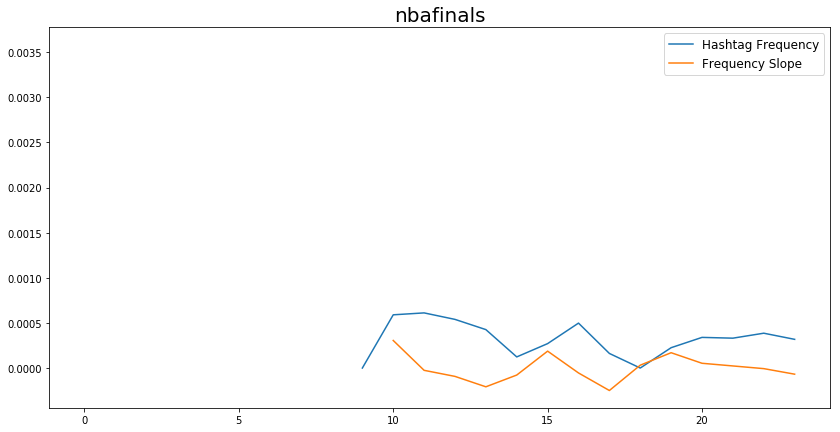

In [65]:
hashtag_trend('nbafinals')

In [88]:
np.argmax(nbafinals_grad).reshape(1,-1)[0]

array([124])

In [ ]:
nbafinals_grad[61]

In [80]:
nbafinals_grad[23]

0.046130180327304676

In [81]:
(np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0])

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([23, 24, 94, 95, 96, 97])

In [82]:
spikes = []
tr = np.argwhere(nbafinals_grad>.01).reshape(1,-1)[0]
[spikes.append(i) for i in tr if (i-1) not in tr]
        
spikes        

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


[23, 94]

In [83]:
np.argmax(nbafinals)

125

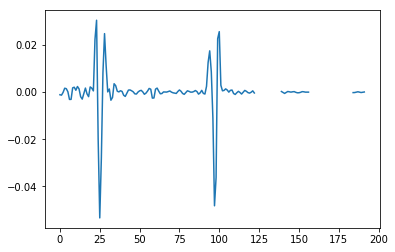

In [84]:
plt.plot(np.gradient(nbafinals_grad))

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


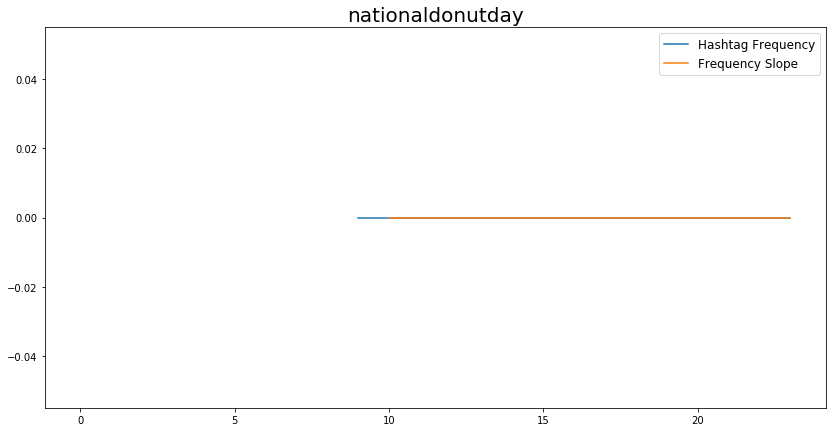

In [66]:
hashtag_trend('nationaldonutday')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


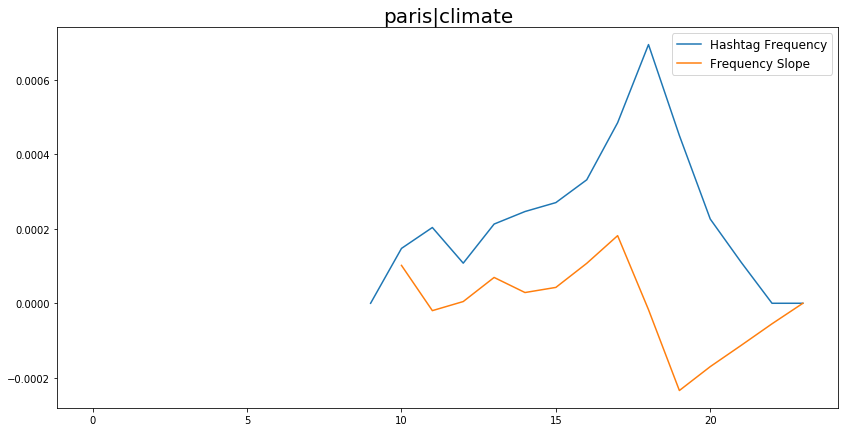

In [67]:
hashtag_trend('paris|climate')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


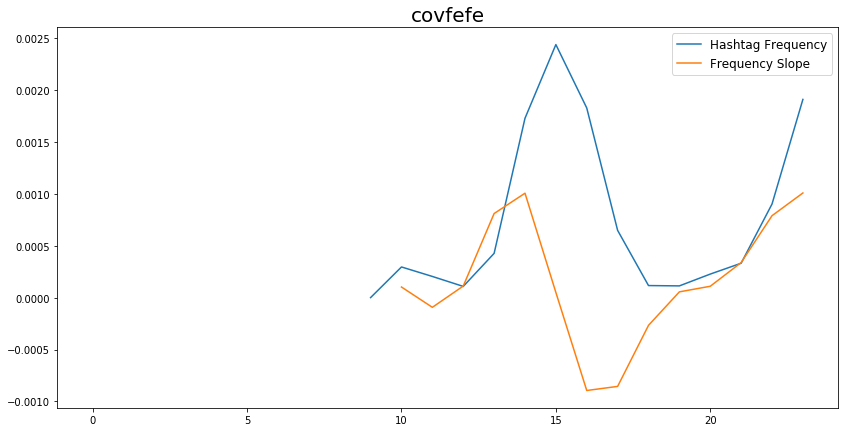

In [68]:
hashtag_trend('covfefe')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


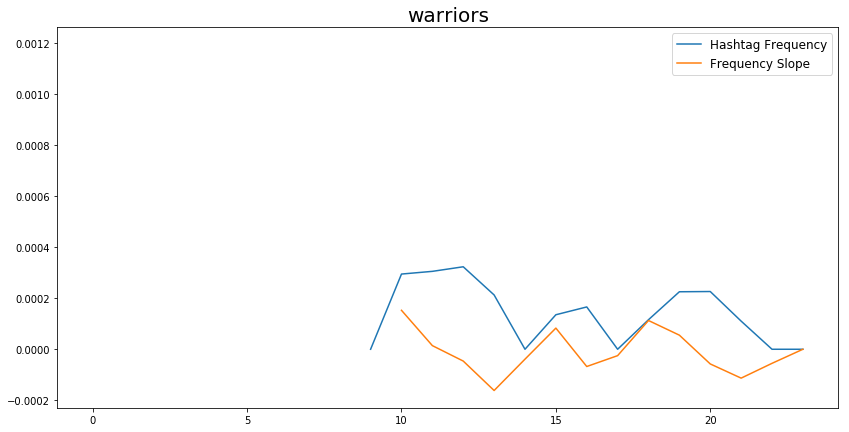

In [69]:
hashtag_trend('Warriors')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


TypeError: 'NoneType' object is not iterable

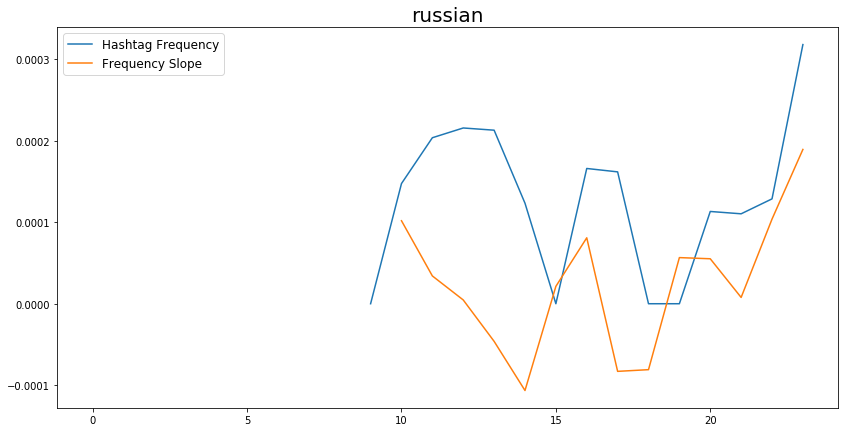

In [70]:
hashtag_trend('Russian')

In [ ]:
hashtag_trend('trump')

In [ ]:
hashtag_trend('china')